# PROJECT 1: Categorizing news articles

### Your task
* Given a bunch of Reuters news service articles, develop a set of labels for categorizing them
* Labels should be a single word or short phrase. Some articles might fit more than one label, and some might not fit any.
* Aim for about 10–15 labels, give or take
* Use methods from labs so far (keyword analysis, terminology extraction, topic models)
* No specific ‘correct’ answer; the process you use to develop the list is more important than the solution.

### Deliverables
* List of labels
* For each label, the number of articles from the dataset that fit that label
* The number of articles that don't fit any of the labels (ideally this won't be a big number)
* Annotated notebook showing your process

In [1]:
import pandas as pd
import numpy as np
from cytoolz import *
import re
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
df = pd.read_parquet('s3://ling583/project1.parquet', storage_options={'anon':True})

In [3]:
df.head()

,headline,text,byline,dateline,date
0,Planet Hollywood launches credit card.,If dining at Planet Hollywood made you feel li...,None,LOS ANGELES,1996-08-20
1,Sprint to offer consumer Internet access service.,Sprint Corp. Tuesday announced plans to offer ...,Susan Nadeau,CHICAGO,1996-08-20
2,Chains may raise prices after minimum wage hike.,The higher minimum wage signed into law Tuesda...,Patricia Commins,CHICAGO,1996-08-20
3,Sprint to offer consumer Internet access service.,Sprint Corp. Tuesday announced plans to offer ...,None,"KANSAS CITY, Mo.",1996-08-20
4,Sprint to offer consumer Internet access service.,Sprint Corp. Tuesday announced plans to offer ...,None,"KANSAS CITY, Mo.",1996-08-20


In [4]:
len(df)

50085

### Guess Language of News Articles 

Define the language of the `text` column and subset the data to select only text in English. 

In [5]:
import pycld2

def guess_lang(text):
    try:
        reliable, _, langs = pycld2.detect(
            text, isPlainText=True, hintLanguage='en')
        if reliable:
            return langs[0][0]
    except pycld2.error as e:
        pass
    return np.NaN

df['lang'] = df['text'].progress_apply(guess_lang)
df = df[df['lang'] == 'ENGLISH'].reset_index(drop=True)

  0%|          | 0/50085 [00:00<?, ?it/s]

In [6]:
len(df)

49844

There are less rows after we subset the data to have English news articles only.

### Find Domain-Specific Terms

We will find domain-specific terminology (multiword expressions, or MWEs) that is relevant for these Reuters news articles.

In [7]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm', exclude=[
                 'parser', 'ner', 'lemmatizer', 'attribute_ruler'])

matcher = Matcher(nlp.vocab)
matcher.add('Term', [[{'TAG': {'IN': ['JJ', 'NN', 'NNP']}},
                      {'TAG': {'IN': ['JJ', 'NN', 'IN',
                                      'HYPH', 'NNP']}, 'OP': '*'},
                      {'TAG': {'IN': ['NN', 'NNP']}}]])


def get_candidates(text):
    doc = nlp(text)
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

Let's parallelize these task to run faster. We will use all samples in the data since there are less than 50K observations.

In [8]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45045")
client

Client Scheduler: tcp://127.0.0.1:45045 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [9]:
import dask.bag as db
import dask.dataframe as dd

texts = dd.from_pandas(df['text'].sample(
    len(df), random_state=19), npartitions=50).to_bag()

graph = texts.map(get_candidates).flatten().frequencies()

In [10]:
%%time

candidates = graph.compute()

CPU times: user 5.25 s, sys: 775 ms, total: 6.02 s
Wall time: 3min 45s


In [11]:
from nltk import ngrams


def get_subterms(term):
    k = len(term)
    for m in range(k-1, 1, -1):
        yield from ngrams(term, m)

In [12]:
from collections import Counter, defaultdict
from math import log2

freqs = defaultdict(Counter)
for c, f in candidates:
    freqs[len(c)][c] += f


def c_value(F, theta):

    termhood = Counter()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

Generate key terms with `theta = 50` first to see if we have a good group of terms. 

In [13]:
terms = c_value(freqs, theta=50)

Look at the 20 most common terms. As we can see here, cities like New York, Hong Kong, and London are big cities and seem to show up the most in the news articles. In addition, air cargo and stock exchange are also some common topics. Past tense description like last years and last week also have high count. In this case, the news article might refer to an older news.  

In [14]:
for t, c in terms.most_common(20):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

 7274.73  7494 new york
 7218.85  7311 hong kong
 6226.87  6325 last year
 5534.74  5879 air cargo
 4348.00  4348 united states
 3915.00  2545 long - distance
 3297.00  3327 percent stake
 3177.43  3226 general cargo
 3085.92  1998 london newsroom +44
 3055.76  3158 chief executive
 2834.62  2268 air cargo newsroom
 2796.00  1830 air cargo newsroom tel+44
 2651.05  2793 stock exchange
 2617.67  2694 net income
 2517.61  2577 co ltd
 2466.00  2466 last week
 2414.20  2464 joint venture
 2299.78  2215 cargo newsroom tel+44
 2294.88  2392 air france
 2261.12  2873 cargo newsroom


And 20 least common terms shows that some terms with more words are less likely to occur in the news article.

In [15]:
for t, c in tail(20, terms.most_common()):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

   50.72    32   net 		  
   50.72    32 market on thursday
   50.72    32 change in accounting
   50.72    32 kreditanstalt fuer wiederaufbau
   50.72    32 meeting on monday
   50.72    32 mass transit railway
   50.72    32 share last year
   50.72    32 first call estimate
   50.72    32 tokyo - narita
   50.72    32 new world development
   50.72    32 weighted average common
   50.72    32 rise in insurance
   50.72    32 cargill private terminal
   50.67   129 f. kennedy
   50.53    18 ex - hong kong air cargo market
   50.53    18 junior transport minister anne - marie idrac
   50.53    18 year - ago 	      jan - sept
   50.53    18 european union trade commissioner sir leon brittan
   50.50    48 group plc   videotron holdings
   50.27    89   golf


I have tried setting `theta` to be 25, 75, 100, and 100. The most frequent words seem like they are similar regardless of what the `theta` value might be. The lower frequency terms are quite different. However, I will continue this analysis with `theta = 50` since the terms in this bucket makes more sense.   

Save the MWEs as a text file so we can use it for next step.

In [16]:
with open('news-article-terms.txt', 'w') as f:
    for t in terms:
        print(' '.join(t), file=f)

### Building topic model and tokenize news articles

In [17]:
# tokenize using a list of terms we've found in 1-prepare
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('news-article-terms.txt'))

We can check out the first tokenized article.

In [18]:
tokenizer.tokenize(df['text'].iloc[0])

['if',
 'dining',
 'at',
 'planet_hollywood',
 'made',
 'you',
 'feel',
 'like',
 'a',
 'movie',
 'star',
 'now',
 'you',
 'can',
 'spend',
 'money',
 'like',
 'arnold',
 'schwarzenegger',
 'with',
 'a',
 'new',
 'credit_card',
 'from',
 'the',
 'themed',
 'restaurant_chain',
 'the',
 'fast',
 'growing',
 'company',
 'whose',
 'outlets',
 'are',
 'festooned',
 'with',
 'kitsch',
 'movie',
 'memorabilia',
 'has',
 'teamed',
 'up',
 'with',
 'the',
 'william',
 'morris',
 'talent',
 'agency',
 'and',
 'mbna',
 'america',
 'bank',
 'of',
 'wilmington',
 'Delaware',
 'to',
 'offer',
 'a',
 'credit_card',
 'with',
 'appropriate',
 'hollywood',
 'perks',
 'these',
 'include',
 'preferential',
 'seating',
 'in',
 'the',
 'restaurants',
 'a',
 'limited',
 'edition',
 't',
 'shirt',
 'and',
 'discounts',
 'on',
 'food',
 'and',
 'merchandise',
 'a',
 'statement',
 'said',
 'planet_hollywood',
 'joins',
 'other',
 'pop',
 'culture',
 'companies',
 'such',
 'as',
 'rolling',
 'stone',
 'magazine'

Token nice the rest of the articles in the dataset. 

In [19]:
df['tokens'] = pd.Series(df['text'].progress_apply(tokenizer.tokenize))

  0%|          | 0/49844 [00:00<?, ?it/s]

### Estimate model

In [20]:
# use tomotopy to built model for topic 
import tomotopy as tp
import time

I have tried different values for these parameters to get the results I want. The values below are the one I think would be good enough to generate topics.

In [21]:
k = 20
min_df = 75  # remove less frequent words
rm_top = 120  # remove most frequency words like stop words
tw = tp.TermWeight.ONE
alpha = 0.1  
eta = 0.01
tol = 1e-3

In [22]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in df['tokens']:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!')

    0 LL = -8.2092
   50 LL = -8.1301
  100 LL = -8.1035
  150 LL = -8.0885
  200 LL = -8.0780
  250 LL = -8.0733
  300 LL = -8.0704
  350 LL = -8.0694
Done!
CPU times: user 4min 15s, sys: 1.86 s, total: 4min 17s
Wall time: 1min 20s


### Evaluate the model 

Look at what terms are associate with what topics.

In [23]:
# list topics 
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  communications, at&t, network, customers, internet, telecommunications, telephone, satellite, system, access
  1  earnings, rose, stock, results, analysts, profits, down, higher, sales, compared
  2  loss, net, net_income, revenues, earnings, expenses, note, 31, income, ended
  3  aircraft, ba, boeing, routes, carrier, british_airways, american, fleet, delta, air
  4  plc, bt, stg, mci, =, pounds, cable, london_newsroom_+44, british, britain
  5  commission, eu, competition, decision, should, rules, open, proposed, any, against
  6  plane, people, passengers, airport, flight, officials, crash, off, aircraft, crew
  7  cents, 9, n, 5, 6, 4, 8, 7, 12, ltd
  8  discharging, waiting, loading, 4, containers, delays, days, berth, general_cargo, 5
  9  hours, rail, french, france, train, drivers, 24, trains, eurotunnel, truckers
 10  australia, australian, stet, dutch, guilders, 504, lire, owned, new_zealand, telstra
 11  port, oil, shipping, ships, ship, ports, tanker, vessel, officials

Check the top most frequent words that we removed. These words are as expected because they are mostly stop words. 

In [24]:
', '.join(mdl.removed_top_words)

"the, to, of, and, a, in, said, on, 's, for, it, is, that, at, $, by, with, was, its, from, be, will, million, as, would, percent, which, are, has, not, he, an, 1, have, company, had, but, we, were, this, up, shares, one, billion, also, year, been, two, they, or, after, new, more, 1996, about, no, 2, over, services, other, their, all, expected, vessels, than, u.s., three, told, companies, government, there, 1997, market, between, share, due, 10, some, could, group, into, per, added, if, airline, wednesday, thursday, tuesday, statement, airlines, monday, 30, our, deal, out, under, tons, business, years, may, state, 3, vs, friday, 20, when, international, service, five, first, 1995, who, i, based, can, flights, now, cargo, 171, 542"

#### Visualize topic model with LDAvis

In [25]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


There are 30 separate topics here, no over lapping, which is good. The topics have separate terms.

In [26]:
pyLDAvis.display(prepared_data)

Find articles that best represent each topic

In [27]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(df['text'].iloc[d])
    print()

0 communications, at&t, network, customers, internet, telecommunications, telephone, satellite, system, access
Motorola Inc said trials are scheduled to begin in the second half of 1997 of new digital cell phone systems for two Japanese providers, under a new contract announced earlier today. Earlier, DDI Corp and IDO Corp, an affiliate of Toyota Motor Corp, said they will jointly introduce a new digital cell phone service in Japan beginning in April 1998. The companies selected Motorola's Cellular Infrastructure Group (CIG) to deploy new digital code division multiple access (CDMA) networks for the service.   Motorola said combined nationwide CDMA coverage with more than 1,500 cell sites is planned for 1999. The value of the contract was not disclosed. Japan is the second largest cellular market in the world, Motorola said. Both networks will use Motorola's SC family of base stations and EMX 2500 mobile switches, the company said. Motorola said CIG's infrastructure equipment is curren

#### WordCloud 

We can checkout what words are the most common using WordCloud. This word cloud is showing the top 200 words in the first topic. 

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

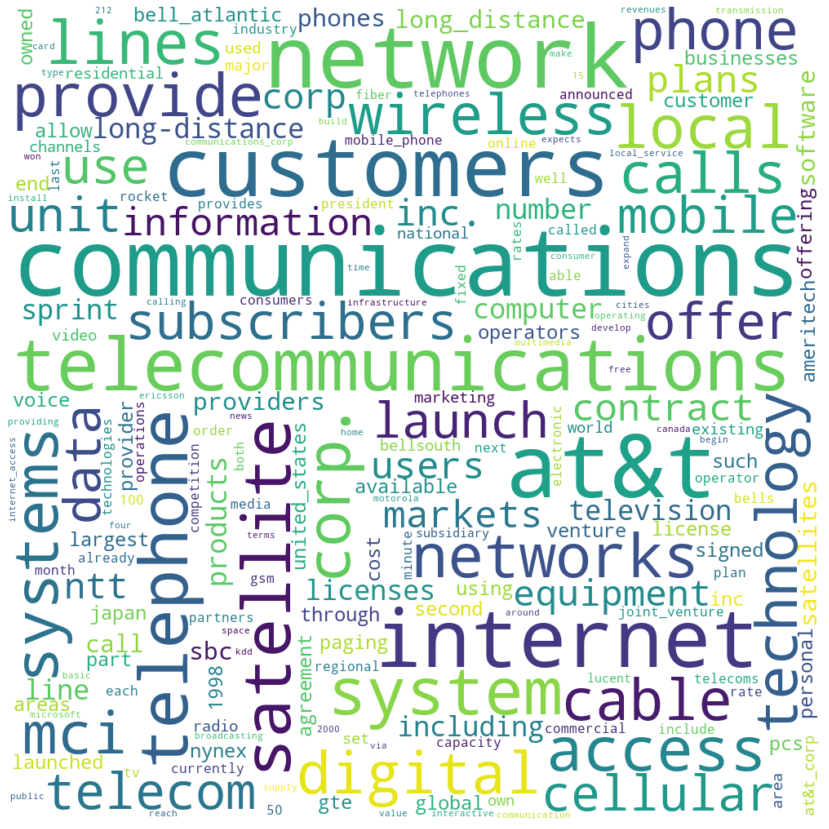

In [29]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(0, 200)) # top 200 words in topic 0
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Save Topics 

First, generate a nice table with one topic column. Then save it as a CSV file. 

In [31]:
for k in range(mdl.k):
    print(k, ', '.join(map(first, mdl.get_topic_words(k))))

0 communications, at&t, network, customers, internet, telecommunications, telephone, satellite, system, access
1 earnings, rose, stock, results, analysts, profits, down, higher, sales, compared
2 loss, net, net_income, revenues, earnings, expenses, note, 31, income, ended
3 aircraft, ba, boeing, routes, carrier, british_airways, american, fleet, delta, air
4 plc, bt, stg, mci, =, pounds, cable, london_newsroom_+44, british, britain
5 commission, eu, competition, decision, should, rules, open, proposed, any, against
6 plane, people, passengers, airport, flight, officials, crash, off, aircraft, crew
7 cents, 9, n, 5, 6, 4, 8, 7, 12, ltd
8 discharging, waiting, loading, 4, containers, delays, days, berth, general_cargo, 5
9 hours, rail, french, france, train, drivers, 24, trains, eurotunnel, truckers
10 australia, australian, stet, dutch, guilders, 504, lire, owned, new_zealand, telstra
11 port, oil, shipping, ships, ship, ports, tanker, vessel, officials, river
12 rates, 7706, airport, f

In [32]:
topics = pd.DataFrame({'words': [' '.join(map(first, mdl.get_topic_words(k))) for k in range(mdl.k)]})

In [33]:
topics.head()

,words
0,communications at&t network customers internet...
1,earnings rose stock results analysts profits d...
2,loss net net_income revenues earnings expenses...
3,aircraft ba boeing routes carrier british_airw...
4,plc bt stg mci = pounds cable london_newsroom_...


In [34]:
topics.to_csv('topics.csv',  index = False)

### Apply label to article

In [35]:
topics = pd.read_csv('topics.csv')

In [36]:
topics['label']

0     communication
1           earning
2           earning
3          aircraft
4           british
5        commission
6          aircraft
7          currency
8             delay
9              rail
10        australia
11             port
12         aircraft
13           london
14            hotel
15          earning
16         industry
17            china
18         aircraft
19         currency
Name: label, dtype: object

In [37]:
# look at the first article
df['text'].iloc[0]

"If dining at Planet Hollywood made you feel like a movie star, now you can spend money like Arnold Schwarzenegger with a new credit card from the themed restaurant chain. The fast growing company, whose outlets are festooned with kitsch movie memorabilia, has teamed up with the William Morris talent agency and MBNA America Bank of Wilmington, Del., to offer a credit card with appropriate Hollywood perks. These include preferential seating in the restaurants, a limited edition T-shirt and discounts on food and merchandise, a statement said. Planet Hollywood joins other pop culture companies such as Rolling Stone magazine that are issuing branded credit cards that make going into debt more fun than usual. Approved applicants don't have to pay an annual fee, and there's a special introductory annual percentage rate of 5.9 percent for balance transfers and cash advance checks. Orlando, Florida-based Planet Hollywood is part of Planet Hollywood International Inc."

In [38]:
mdl.docs[0]

<tomotopy.Document with words="if dining at planet_hollywood made you feel like a movie star now you can spend money like arnold schwarzenegger with a new credit_card from the themed restaurant_chain the fast growing company whose outlets are festooned with kitsch movie memorabilia has teamed up with the william morris talent agency and mbna america bank of wilmington Delaware to offer a credit_card with appropriate hollywood perks these include preferential seating in the restaurants a limited edition t shirt and discounts on food and merchandise a statement said planet_hollywood joins other pop culture companies such as rolling stone magazine that are issuing branded credit cards that make going into debt more fun than usual approved applicants do not have to pay an annual fee and there 's a special introductory annual percentage rate of 5.9 percent for balance transfers and cash advance checks orlando florida based planet_hollywood is part of planet_hollywood_international inc.">

In [39]:
mdl.docs[0].get_topics()

[(16, 0.4203474521636963),
 (14, 0.4043061435222626),
 (0, 0.16536615788936615),
 (1, 0.0012829273473471403),
 (15, 0.0011747130192816257),
 (5, 0.0010977624915540218),
 (17, 0.0009160916088148952),
 (3, 0.0007367492653429508),
 (12, 0.0006493363180197775),
 (11, 0.000569602008908987)]

Since some topics have really low frequency, we would want to set a thredsold to get a higher frequency topics. 

In [40]:
[t for t, w in mdl.docs[0].get_topics() if w > 0.01]

[16, 14, 0]

#### Look at label for each topic 

Here is a set of all labels that are from the first article.

In [41]:
[topics['label'].loc[t] for t, w in mdl.docs[0].get_topics() if w > 0.01]

['industry', 'hotel', 'communication']

Now, we need to create a loop to find labels for all articles.

In [42]:
label_df = []
for i in range(len(df)):
    label_df.append([topics['label'].loc[t] for t, w in mdl.docs[i].get_topics() if w > 0.01])
    

In [43]:
label_df = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, label_df) for i in b]

### Number of articles from the dataset that fit each label

As we can see here, the label earning, aircraft, and commission got mentioned the most in the news articles. 

In [45]:
Counter(label_df)

Counter({'industry': 24731,
         'hotel': 12708,
         'communication': 13732,
         'aircraft': 33494,
         'earning': 39683,
         'currency': 5523,
         'rail': 6199,
         'british': 5872,
         'china': 12335,
         'commission': 14369,
         'london': 3613,
         'australia': 5353,
         'port': 8027,
         'delay': 2071})

### The number of articles that don't fit any of the labels

Here, there are no article that don't have a match to any labels.

In [79]:
number_of_non_lables = 0
for i in range(len(df)):
    if len([topics['label'].loc[t] for t, w in mdl.docs[i].get_topics() if w > 0.01]) == 0: 
        number_of_non_lables += 1

number_of_non_lables

0

However, let's check if there is any article that don't have any match with `w > 0.20`. As seen below, there are 5 articles that have really low proportion of matching nay of the label in our dataset. Of course, when we increase the value of `w` the number of unmatched article will be higher.

In [81]:
number_of_non_lables = 0
for i in range(len(df)):
    if len([topics['label'].loc[t] for t, w in mdl.docs[i].get_topics() if w > 0.20]) == 0: 
        number_of_non_lables += 1
        
number_of_non_lables

5